<a href="https://colab.research.google.com/github/roseandgold/HatefulMemesProject/blob/main/BERT%20Model/BERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Model
Some code was adapted from Coursera guided project Sentiment Analysis with BERT

Best if run in Colab using GPU

## Step 1: Load the Data

In [1]:
%%capture
!pip install transformers

In [55]:
import torch
import random
import cv2
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Import necessary files
train_file = '/content/drive/MyDrive/SIADS 697 - Capstone/SIADS 697 - Capstone/hateful_memes/train.jsonl'
test_file = '/content/drive/MyDrive/SIADS 697 - Capstone/SIADS 697 - Capstone/hateful_memes/dev_seen.jsonl'
final_test_file = '/content/drive/MyDrive/SIADS 697 - Capstone/SIADS 697 - Capstone/hateful_memes/test_seen.jsonl'

train_data = pd.read_json(train_file, lines = True)
test_data = pd.read_json(test_file, lines = True)
final_test_data = pd.read_json(final_test_file, lines = True)
test_data.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


## Step 2: Loading Tokenizer and Encoding our Data

In [6]:
# Create the tokenizer
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Adapted from Coursera guided project "Sentiment Analysis with BERT"
encoded_data_train = tokenizer.batch_encode_plus(
    train_data.text.values,
    add_special_tokens=True, # set this so BERT knows when a sentence ends and begins
    return_attention_mask=True, #using a fixed input, all sentences have same dimensionality. Tells us where actual values are and where zeros are
    padding = True, # make sure to pad sentences so they are all the same length
    max_length = 256, # this is the length we want all senteces to be
    return_tensors = 'pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    test_data.text.values,
    add_special_tokens=True, # set this so BERT knows when a sentence ends and begins
    return_attention_mask=True, #using a fixed input, all sentences have same dimensionality. Tells us where actual values are and where zeros are
    padding = True, # make sure to pad sentences so they are all the same length
    max_length = 256, # this is the length we want all senteces to be
    return_tensors = 'pt'
)

encoded_final_test= tokenizer.batch_encode_plus(
    final_test_data.text.values,
    add_special_tokens=True, # set this so BERT knows when a sentence ends and begins
    return_attention_mask=True, #using a fixed input, all sentences have same dimensionality. Tells us where actual values are and where zeros are
    padding = True, # make sure to pad sentences so they are all the same length
    max_length = 256, # this is the length we want all senteces to be
    return_tensors = 'pt'
)

# get the parts from the encoding that need to train the model
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(test_data.label.values)

input_ids_final_test = encoded_final_test['input_ids']
attention_masks_final_test = encoded_final_test['attention_mask']
labels_final_test = torch.tensor(final_test_data.label.values)

In [9]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_final_test = TensorDataset(input_ids_final_test, attention_masks_final_test, labels_final_test)

In [10]:
print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_final_test))

8500
500
1000


## Step 3: Setting up BERT Pretrained Model

In [11]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=len(train_data.label.unique()),
    output_attentions=False,
    output_hidden_states=False
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Step 4: Creating Data Loaders

In [27]:
# Adapted from Coursera guided project "Sentiment Analysis with BERT"
batch_size=32

dataloader_train=DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val=DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

dataloader_final_test = DataLoader(
    dataset_final_test,
    batch_size=32
)

## Step 5: Setting Up Optimizer and Scheduler

In [13]:
# Adam is a stochastic optimization
optimizer = AdamW(
    model.parameters(),
    lr= 1e-5, #2e-5 > 5e -5
    eps=1e-8
)

In [14]:
epochs = 30

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) *epochs
)

## Step 6: Defining our Performance Metric

In [15]:
def auc(preds, labels):
    preds_flat=np.argmax(preds, axis=1).flatten()
    labels_flat=labels.flatten()
    return roc_auc_score(labels_flat, preds_flat)

## Step 7: Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [16]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val) #usually if using GPU

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [18]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [17]:
for epoch in tqdm(range(1, epochs+1)):
    model.train() # put model in training mode
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                       leave = False,
                       disable = False)
    for batch in progress_bar:
        
        model.zero_grad() # set the gradient to zero
        
        batch = tuple(b.to(device) for b in batch) # make sure each item on device
        
        # get the inputs to the model
        inputs = {
            'input_ids': batch[0],
            'attention_mask' : batch[1],
            'labels': batch[2]
        }
    
        # get the outputs
        outputs = model(**inputs)
        
        #BERT returns loss and logits
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # backpropagation
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevents gradient from getting too small or too big
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/SIADS 697 - Capstone/SIADS 697 - Capstone/hateful_memes/models/BERT2_ft_epoch{epoch}.model')
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_value = evaluate(dataloader_val)
    val_AUC = auc(predictions, true_value)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'AUC Score: {val_AUC}')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5719578149623441


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 0.7584730572998524
AUC Score: 0.5782192635739546


Epoch 2:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.47625671349521864


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 0.8257372453808784
AUC Score: 0.5579283416812022


Epoch 3:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.42124832029405396


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 0.8423961475491524
AUC Score: 0.5702181114080428


Epoch 4:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3684859047818901


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 0.96541628241539
AUC Score: 0.5514714118833112


Epoch 5:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.33066521100419805


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.0855311341583729
AUC Score: 0.545782592693348


Epoch 6:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3015096060427508


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.0291270054876804
AUC Score: 0.5484309740602646


Epoch 7:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.2737888760472599


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.1045880932360888
AUC Score: 0.5489590501032149


Epoch 8:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.2547398994123577


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.4028592184185982
AUC Score: 0.5459266134323343


Epoch 9:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.23602228033307351


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.415572490543127
AUC Score: 0.544862460194268


Epoch 10:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.22176580848102284


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.5536644347012043
AUC Score: 0.5423580995663375


Epoch 11:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.21049973015722476


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.6348429769277573
AUC Score: 0.5523355363172296


Epoch 12:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.20289130894033083


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.5303997322916985
AUC Score: 0.5468867516922437


Epoch 13:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1957251258068403


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.7607642114162445
AUC Score: 0.5483829671472692


Epoch 14:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.19006971750212343


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.9873900562524796
AUC Score: 0.5459746203453297


Epoch 15:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.18706956004401795


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.9699106961488724
AUC Score: 0.5402858011553664


Epoch 16:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.17908999712479517


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.9307439550757408
AUC Score: 0.5480949256692964


Epoch 17:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.17457437497052483


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.9866973087191582
AUC Score: 0.5384535373093726


Epoch 18:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.17012636972717324


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 1.9203369170427322
AUC Score: 0.540861884111312


Epoch 19:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1614355666254808


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.2451968863606453
AUC Score: 0.54650269638828


Epoch 20:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.16341579718081126


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.1946706771850586
AUC Score: 0.5503592517322494


Epoch 21:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.16110707252265366


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.187012106180191
AUC Score: 0.548671008625242


Epoch 22:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.15708363523594754


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.2504109889268875
AUC Score: 0.548671008625242


Epoch 23:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.15596621423343518


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.3531126007437706
AUC Score: 0.5384535373093726


Epoch 24:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.15190433187032104


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.3727676197886467
AUC Score: 0.5424541133923285


Epoch 25:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.15309359440650033


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.401892051100731
AUC Score: 0.5424541133923285


Epoch 26:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.14863483845151232


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.3979004696011543
AUC Score: 0.5486230017122466


Epoch 27:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.14648299959061065


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.551176019012928
AUC Score: 0.5443823910643133


Epoch 28:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.14692456855025507


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.4955871030688286
AUC Score: 0.5444784048903042


Epoch 29:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1440174859664858


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.6044616773724556
AUC Score: 0.5443823910643133


Epoch 30:   0%|          | 0/266 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.1415129067180188


  0%|          | 0/16 [00:00<?, ?it/s]

Validation loss: 2.5800046399235725
AUC Score: 0.5444784048903042


## Step 8: Loading and Evaluating our Model

In [19]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(train_data.label.unique()),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)
pass

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [21]:
# load a pretrained model
model.load_state_dict(
    torch.load('/content/drive/MyDrive/SIADS 697 - Capstone/SIADS 697 - Capstone/hateful_memes/BERT models/BERT2_ft_epoch1.model',
    map_location = torch.device('cpu'))
)

<All keys matched successfully>

In [28]:
# Get the predictions for the hold out test set
_, predictions, true_vals = evaluate(dataloader_final_test)

  0%|          | 0/32 [00:00<?, ?it/s]

In [23]:
# Get the predictions for the training set
_, train_predictions, train_true_vals = evaluate(dataloader_train)

  0%|          | 0/266 [00:00<?, ?it/s]

In [48]:
# Get the AUC on the hold out test set
final_test_auc = auc(predictions, true_vals)
train_auc = auc(train_predictions, train_true_vals)
print(final_test_auc)
print(train_auc)

0.6019007603041217
0.7506777455607281


In [25]:
# Create the roc curve
def create_roc_curve(test_predictions, test_true_vals, train_predictions, train_true_vals, final_test_auc):
    test_fpr, test_tpr, _ = roc_curve(test_true_vals, test_predictions, pos_label = 1)
    train_fpr, train_tpr, _ = roc_curve(train_true_vals, train_predictions, pos_label = 1)
    
    # Create a dataframe of fpr and tpr to create visual
    testRocDf = pd.DataFrame({'fpr': test_fpr, 'tpr': test_tpr, 'data':['test']*len(test_tpr)})
    trainRocDf = pd.DataFrame({'fpr': train_fpr, 'tpr': train_tpr, 'data': ['train'] * len(train_tpr)})
    rocDf = pd.concat([testRocDf, trainRocDf])

    # Create the ROC curve
    fig = px.line(rocDf, 
                  x = 'fpr', 
                  y = 'tpr',
                  color = 'data',
                  color_discrete_sequence=['orange', 'blue'],
                 title = 'BERT ROC Curve (Test AUC: {})'.format(round(final_test_auc,2)))
    fig.update_layout({
        'plot_bgcolor': 'rgba(0,0,0,0)',
        'paper_bgcolor':'rgba(0,0,0,0)'
    })
    fig.show()
    return rocDf

In [26]:
rocDf = create_roc_curve(predictions[:,1], true_vals, train_predictions[:,1], train_true_vals, final_test_auc)

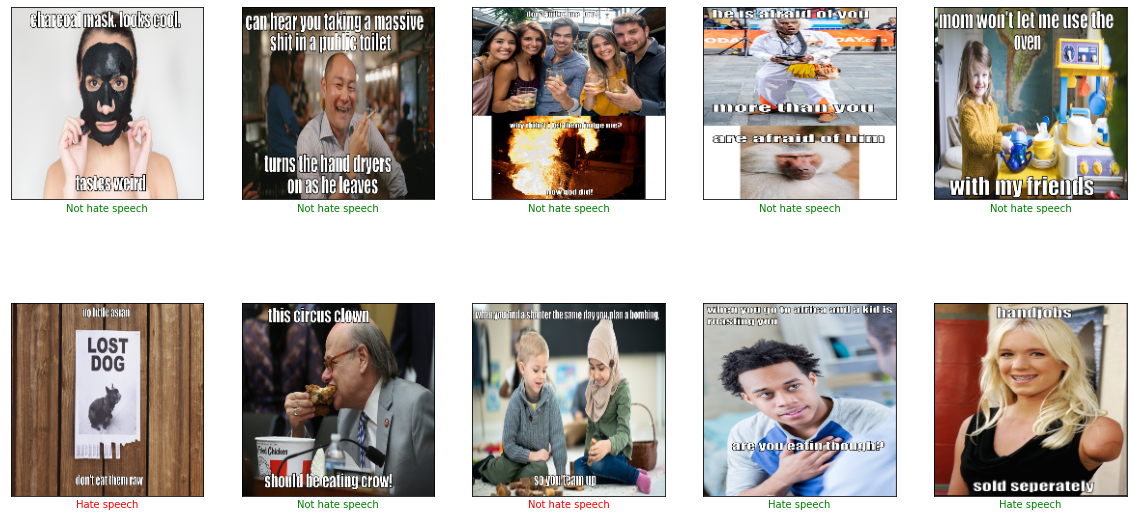

In [51]:
# Get samples of memes
img_dir = '/content/drive/MyDrive/SIADS 697 - Capstone/SIADS 697 - Capstone/hateful_memes/'

# Code adapted from Coursera project Image Classification with CNN using Keras
class_names = ['Not hate speech', 'Hate speech']


samples = final_test_data.reset_index().sample(10, replace=False)
indices = samples.index

x = []
for file in samples.img:
  img = cv2.imread(img_dir + file)
  img = cv2.resize(img, (200, 200)) # resize
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # make sure color is correct
  x.append(img)


x = np.array(x)
y = true_vals[indices]
p = predictions[indices]
    
plt.figure(figsize = (20,10))
for i in range(10):
    plt.subplot(2,5, 1 + i)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    col = 'green' if y[i] == np.argmax(p[i]) else 'red'
    plt.xlabel(class_names[np.argmax(p[i])], color = col)
plt.show()

In [57]:
# What is the accuracy
prediction_labels = []
for pred in predictions:
    if np.argmax(pred) == 1:
      prediction_labels.append(1)
    else:
      prediction_labels.append(0)
  
accuracy_score(true_vals, prediction_labels)

0.607

In [61]:
# What % of each class did it accurately predict?
hateful = 0
nonhateful = 0

for idx, label in enumerate(true_vals):
  if label == prediction_labels[idx]:
    if label == 1:
      hateful += 1
    else:
      nonhateful +=1 

print(hateful/sum(true_vals))
print(nonhateful/(len(true_vals) - sum(true_vals)))

0.3469387755102041
0.8568627450980392
